In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation
import random

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins, nbrh_WG_open, mid_cum_Z4_sec
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
date_consistent_barn_schedule = config.date_consistent_barn_schedule
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


# download data

In [5]:
#mvt data
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,7,25)]
print(df_daily.shape)
df_daily.head(3)

(39382, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


In [6]:
#daily var
path_ = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput\order103345'
df = pd.read_csv(os.path.join(path_, 'order_103345_data.txt'), sep=';',
                 parse_dates=['time'],
                 dayfirst=True) 
df['date'] = df['time'].map(lambda x: dt.datetime(x.year, x.month, x.day))
df['time'] = df['time'].map(lambda x: dt.datetime.time(x))
df = df[(df['time']>dt.time(9,0,0))&(df['time']<dt.time(17,0,0))]
print(df.shape)
df.head(3)

(14288, 4)


,stn,time,sre000z0,date
55,BER,09:10:00,0,2020-01-10
56,BER,09:20:00,0,2020-01-10
57,BER,09:30:00,0,2020-01-10


In [7]:
print(df[df['sre000z0']==0].shape)
print(df[df['sre000z0']!=0].shape)

(7375, 4)
(6913, 4)


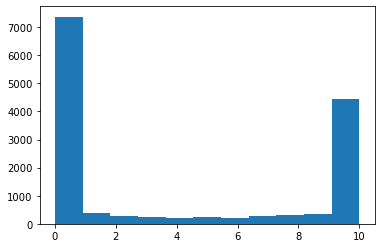

In [9]:
plt.hist(df['sre000z0'], bins=11);

In [11]:
df[df['date']==dt.datetime(2020,1,10)]

,stn,time,sre000z0,date
55,BER,09:10:00,0,2020-01-10
56,BER,09:20:00,0,2020-01-10
57,BER,09:30:00,0,2020-01-10
58,BER,09:40:00,0,2020-01-10
59,BER,09:50:00,0,2020-01-10
60,BER,10:00:00,1,2020-01-10
61,BER,10:10:00,6,2020-01-10
62,BER,10:20:00,1,2020-01-10
63,BER,10:30:00,0,2020-01-10
64,BER,10:40:00,0,2020-01-10


In [52]:
df[(df['time']>dt.time(10,0,0))&(df['time']<dt.time(17,0,0))]

,stn,time,sre000z0,date
61,BER,10:10:00,6,2020-01-10 10:10:00
62,BER,10:20:00,1,2020-01-10 10:20:00
63,BER,10:30:00,0,2020-01-10 10:30:00
64,BER,10:40:00,0,2020-01-10 10:40:00
65,BER,10:50:00,0,2020-01-10 10:50:00
...,...,...,...,...
43729,BER,16:10:00,0,2021-07-31 16:10:00
43730,BER,16:20:00,0,2021-07-31 16:20:00
43731,BER,16:30:00,0,2021-07-31 16:30:00
43732,BER,16:40:00,0,2021-07-31 16:40:00


In [25]:
df['sre000z0'].value_counts(normalize=True)

0     0.770742
10    0.149785
1     0.012221
9     0.010965
8     0.008932
2     0.008909
7     0.008498
3     0.007790
5     0.007744
4     0.007401
6     0.007013
Name: sre000z0, dtype: float64

### put into format for behavioural tendency measure

### behavioural tendency

In [ ]:
def behavioural_tendency(li_B, config, dico_nbr_liFAKEdate, tupleFR_h_mn,
                                Nbr_random, fake_sec=0, onlydurnottiming=False):
    '''compute behavioural tendency of behaviur B under S. One value per HenID (column) and per day will be computed. 
    a dataframe of the metadata about the period will be outputed too, that could be used to control and add drivers at each specific
    periods based on their specified timestamps.
    Inputs:
    li_B: list of behaviors (0: not performing it, 1: perfomring it, -1: not to be accoutned for)
    li_driver'''
    #put into good format and check if the length corresponds to what is expected (2h-16h59)
    #from 1_zone to 1
    if len(li_Z)!=15*60*60:
        return (np.nan, np.nan, [np.nan], [np.nan], np.nan, np.nan)
    
    #initialise known parameters from configuration file
    dur_FR_beforeandafter_mn = config.dur_FR_beforeandafter_mn
   
    #initialise output values
    tFZ_ALL = []
    tFZ_ALL_FAKE = []
    li_res = []
    li_li_res = []
    
    if onlydurnottiming:
        li_choices = []
        for v in config.dico_nbr_liFAKEdate.values():
            li_choices.extend(v)
    
    #intialise the number of batch we will consider for that day-hen
    nbr_batch_considered = 0
    #initialise a dico with a list of zone where the hen was for each time the food was delivered
    dico_nbr_liz = {}
    for nbr,(h,mn) in enumerate(tupleFR_h_mn):
        
        #extract a list of the zone where the hen was during that batch of food delivery
        #substract 2 as it starts at 2h
        li_ = li_Z[((h-2)*60*60+mn*60-dur_FR_beforeandafter_mn*60)+fake_sec:((h-2)*60*60+mn*60+dur_FR_beforeandafter_mn*60)+fake_sec]
        dico_nbr_liz[nbr] = li_
        if len(li_)!=4*60:
            print(len(li_))
            print('ERROR ELSE DELETE THIS HERE')
            sys.exit()
        
        #compute time in a food zone and time inside
        tFZ = sum([(v==3)|(v==5) for v in li_])
        tFZINSIDE = sum([(v!=1) for v in li_])
            
        #then, for each period of food delivery, and for each cases where the hen was inside the whole time, 
        #we take a surrounding random period, without accounting the 20mn before or after food delivery, and chose a 
        #random period (but that does not include WG, just as the food timing batch time)
        if tFZINSIDE==4*60:
            #if hen is inside the whole period, we will consider that batch (and normalize with)
            nbr_batch_considered = nbr_batch_considered + 1
            #without replacement, choose Nbr_random element from the list
            li_todo = random.sample(dico_nbr_liFAKEdate[nbr+1], Nbr_random*3) #*3 as the hen should be outside
            if onlydurnottiming:
                li_todo = random.sample(li_choices, Nbr_random*3)
            #for each fake starting time, compute the duration in food zone and output the mean
            li_tFZ_fake = []
            k = 0
            while k < Nbr_random:
                for faketime in li_todo:
                    h_ = faketime.hour
                    mn_ = faketime.minute
                    sec_ = faketime.second
                    li_fakezone = li_Z[((h_-2)*60*60+mn_*60+sec_):((h_-2)*60*60+mn_*60+sec_+dur_FR_beforeandafter_mn*60*2)]
                    if len(li_fakezone)!=4*60:
                        print(len(li_fakezone), h_, mn_, sec_)
                        print('ERROR ELSE DELETE THIS HERE')
                        sys.exit()
                    #if never went outside then keep it
                    tFZINSIDE_fake = sum([(v!=1) for v in li_])
                    if tFZINSIDE_fake==4*60:
                        #compute time in a food zone vs time in a non food zone
                        tFZ_fake = sum([(v==3)|(v==5) for v in li_fakezone])
                        li_tFZ_fake.append(tFZ_fake)
                        k = k +1
            #add the duration in foodzone based on random timing to the list for all the food-batches
            li_thisperiod_res = [(tFZ-v)/(tFZ+v) if (tFZ+v)!=0 else 0 for v in li_tFZ_fake]
            li_li_res.append(li_thisperiod_res) #verified, correct
            tFZ_ALL.append(tFZ)
            tFZ_ALL_FAKE.append([round(v,2) for v in li_tFZ_fake])
            li_res.append(np.mean(li_thisperiod_res))
        else:
            #keep track of which period was not available
            li_li_res.append([np.nan])
            tFZ_ALL.append(np.nan)
            tFZ_ALL_FAKE.append([np.nan])
            li_res.append(np.nan)
            
    return (round(np.nansum(li_res)/nbr_batch_considered,2), tFZ_ALL, tFZ_ALL_FAKE, li_li_res, nbr_batch_considered, li_res)